In [1]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# **Analyses of Language Dependencies for Boardgames**

**Objective:** 

Assessment of boardgames available on Boardgame Geek API (BGG) to determine trends concerning language dependencies for game categories, game mechanics and rankings. Following section contains minor clean up of data.

Note: language_dependencies_eda file contains the plots for use.
Note 2: language_dependencies file contains the creation of the language dependency database.

In [2]:
lang_df = pd.read_csv('../data/language_vote_details.csv', low_memory=False)
df = pd.read_csv('../data/cleaned2.csv', low_memory=False)
ranks = pd.read_csv('../data/boardgames_ranks.csv', low_memory=False)

df['categories'] = df['categories']\
    .apply(lambda x: ast.literal_eval(x))
df['mechanics'] = df['mechanics']\
    .apply(lambda x: ast.literal_eval(x))

In [3]:
ranks.rename(columns={"id":"@id"}, inplace = True)
lang_df.rename(columns={"Language Dependency": "lang"}, inplace = True)

lang_df.head(2)

,@id,language_poll,Not Dependent,Somewhat,Moderately,Extensively,Fully,lang
0,1,"[[{'@level': '1', '@value': 'No necessary in-g...",37,5,7,0,0,Not Dependent
1,2,"[[{'@level': '6', '@value': 'No necessary in-g...",0,1,0,0,0,Somewhat


In [4]:
#correcting the lang column info for games with no votes

def no_language(row):
    if row["Not Dependent"] == 0 and \
        row["Somewhat"] == 0 and \
        row["Moderately"] == 0 and \
        row["Extensively"] == 0 and \
        row["Fully"] == 0:
        return "No Info"
    else: 
        return row["lang"]

lang_df["lang"] = lang_df.apply(no_language, axis = 1)

lang_df.head(2)

,@id,language_poll,Not Dependent,Somewhat,Moderately,Extensively,Fully,lang
0,1,"[[{'@level': '1', '@value': 'No necessary in-g...",37,5,7,0,0,Not Dependent
1,2,"[[{'@level': '6', '@value': 'No necessary in-g...",0,1,0,0,0,Somewhat


## **Part 1: Metrics for Game Titles, Rankings, and Language Dependencies**

### **1A. Data Prep**

In [5]:
# Data prep. Creating df containing columns for id, name, year, language, ranks 

merge_df = pd.merge(df[["@id", "name" , "year"]], ranks[["@id","rank"]], on = "@id", how = "inner")
games_df = pd.merge(merge_df, lang_df[["@id","lang"]], on = "@id", how = "inner")   

games = games_df.copy()
games.dropna(inplace = True)
display(games.head(2))

,@id,name,year,rank,lang
0,1,Die Macher,1986,409,Not Dependent
1,2,Dragonmaster,1981,4819,Somewhat


In [6]:
# bin by decade
bins = [1960, 1970, 1980, 1990, 2000, 2010, 2020, 2030]
labels = ["1960s", "1970s", "1980s", "1990s", "2000s", "2010s", "2020s"]
games["decade"] = pd.cut(games["year"], bins = bins, labels = labels, right = False)


#display df output and some ranking info
no_rank = (games["rank"] != 0).sum()
display(games.head())
print(f"Number of games that have rankings: {no_rank}")
print(f"Lowest game ranking is: {games['rank'].max()}")

,@id,name,year,rank,lang,decade
0,1,Die Macher,1986,409,Not Dependent,1980s
1,2,Dragonmaster,1981,4819,Somewhat,1980s
2,3,Samurai,1998,266,Not Dependent,1990s
3,4,Tal der Könige,1992,6440,Not Dependent,1990s
4,5,Acquire,1963,335,Not Dependent,1960s


Number of games that have rankings: 25807
Lowest game ranking is: 25809


In [7]:
# add columns for grouped game ranks (e.g. games ranked 1 - 100, games ranked 101-500, etc)

def rank_groups(value, label):
    if value == "":
        return pd.NA
    value = int(value)
    
    if label == grouped_rankings[0] and value <= 100:
        return "True"
    elif label == grouped_rankings[1] and value >= 101 and value <= 500:
        return "True"
    elif label == grouped_rankings[2] and value >= 501 and value <= 1000:
        return "True"
    elif label == grouped_rankings[3] and value >= 1001 and value <= 2500:
        return "True"
    elif label == grouped_rankings[4] and value >= 2501 and value <= 4999:
        return "True"
    elif label == grouped_rankings[5] and value > 5000:
        return "True"
    else:
        return pd.NA

grouped_rankings = ["1 - 100", "101-500","501 - 1000", "1001 - 2500", "2501 - 4999", "5000+"]


for label in grouped_rankings:
    games[label] = games["rank"].apply(lambda row: rank_groups(row, label))
    
    
games.head()

,@id,name,year,rank,lang,decade,1 - 100,101-500,501 - 1000,1001 - 2500,2501 - 4999,5000+
0,1,Die Macher,1986,409,Not Dependent,1980s,<NA>,True,<NA>,<NA>,<NA>,<NA>
1,2,Dragonmaster,1981,4819,Somewhat,1980s,<NA>,<NA>,<NA>,<NA>,True,<NA>
2,3,Samurai,1998,266,Not Dependent,1990s,<NA>,True,<NA>,<NA>,<NA>,<NA>
3,4,Tal der Könige,1992,6440,Not Dependent,1990s,<NA>,<NA>,<NA>,<NA>,<NA>,True
4,5,Acquire,1963,335,Not Dependent,1960s,<NA>,True,<NA>,<NA>,<NA>,<NA>


In [8]:
games = games.convert_dtypes()

In [9]:
#creating df for games that have been ranked, non ranks were dropped as were games with no language info

drop_zero = games["rank"] == 0
games_rankings = games.drop(games[drop_zero].index)

drop_noinfo = games_rankings["lang"] == "No Info"
games_rankings = games_rankings.drop(games_rankings[drop_noinfo].index)

display(games_rankings.head(2))

drop_all_notdepend = games_rankings["lang"] != "Not Dependent"
not_dependent = games_rankings.drop(games_rankings[drop_all_notdepend].index)
not_dependent.sort_values(by="rank", inplace=True)

display(not_dependent.head())

,@id,name,year,rank,lang,decade,1 - 100,101-500,501 - 1000,1001 - 2500,2501 - 4999,5000+
0,1,Die Macher,1986,409,Not Dependent,1980s,<NA>,True,<NA>,<NA>,<NA>,<NA>
1,2,Dragonmaster,1981,4819,Somewhat,1980s,<NA>,<NA>,<NA>,<NA>,True,<NA>


,@id,name,year,rank,lang,decade,1 - 100,101-500,501 - 1000,1001 - 2500,2501 - 4999,5000+
76142,224517,Brass: Birmingham,2018,1,Not Dependent,2010s,True,<NA>,<NA>,<NA>,<NA>,<NA>
75475,220308,Gaia Project,2017,12,Not Dependent,2010s,True,<NA>,<NA>,<NA>,<NA>,<NA>
70720,193738,Great Western Trail,2016,15,Not Dependent,2010s,True,<NA>,<NA>,<NA>,<NA>,<NA>
44188,84876,The Castles of Burgundy,2011,16,Not Dependent,2010s,True,<NA>,<NA>,<NA>,<NA>,<NA>
65628,173346,7 Wonders Duel,2015,18,Not Dependent,2010s,True,<NA>,<NA>,<NA>,<NA>,<NA>


### **1B. Pivots and Plots**

In [10]:
#Pivoted to see if anything interesting regarding language dependencies and game popularity (grouped by rankings groups)

reorder_lang_dec= ["Not Dependent", "Somewhat", "Moderately", "Extensively", "Fully"]

rankings_vs_lang = pd.pivot_table(games_rankings, 
                                index = 'lang', 
                                values = ["1 - 100", "101-500","501 - 1000", "1001 - 2500", "2501 - 4999", "5000+"],
                                aggfunc='count')

rankings_vs_lang = rankings_vs_lang[grouped_rankings]



reorder_lang_dec= ["Not Dependent", "Somewhat", "Moderately", "Extensively", "Fully"]

rankings_vs_lang = rankings_vs_lang.reindex(reorder_lang_dec)

display(rankings_vs_lang)

#updated the table's values to percentages.
def convert_to_percent(col):
    total_sum = col.sum()
    return col / total_sum

rankings_vs_lang_perc = rankings_vs_lang.apply(convert_to_percent) 



rankings_vs_lang_perc = rankings_vs_lang_perc.reindex(reorder_lang_dec).round(2)
display(rankings_vs_lang_perc)


,1 - 100,101-500,501 - 1000,1001 - 2500,2501 - 4999,5000+
lang,,,,,,
Not Dependent,29,147,199,625,1009,6018
Somewhat,7,62,100,302,474,2216
Moderately,25,110,107,297,506,3530
Extensively,36,70,80,233,350,1602
Fully,3,11,14,39,54,656


,1 - 100,101-500,501 - 1000,1001 - 2500,2501 - 4999,5000+
lang,,,,,,
Not Dependent,0.29,0.37,0.40,0.42,0.42,0.43
Somewhat,0.07,0.16,0.20,0.20,0.20,0.16
Moderately,0.25,0.28,0.21,0.20,0.21,0.25
Extensively,0.36,0.18,0.16,0.16,0.15,0.11
Fully,0.03,0.03,0.03,0.03,0.02,0.05


### 2. Plot to see the language dependencies per game rankings.

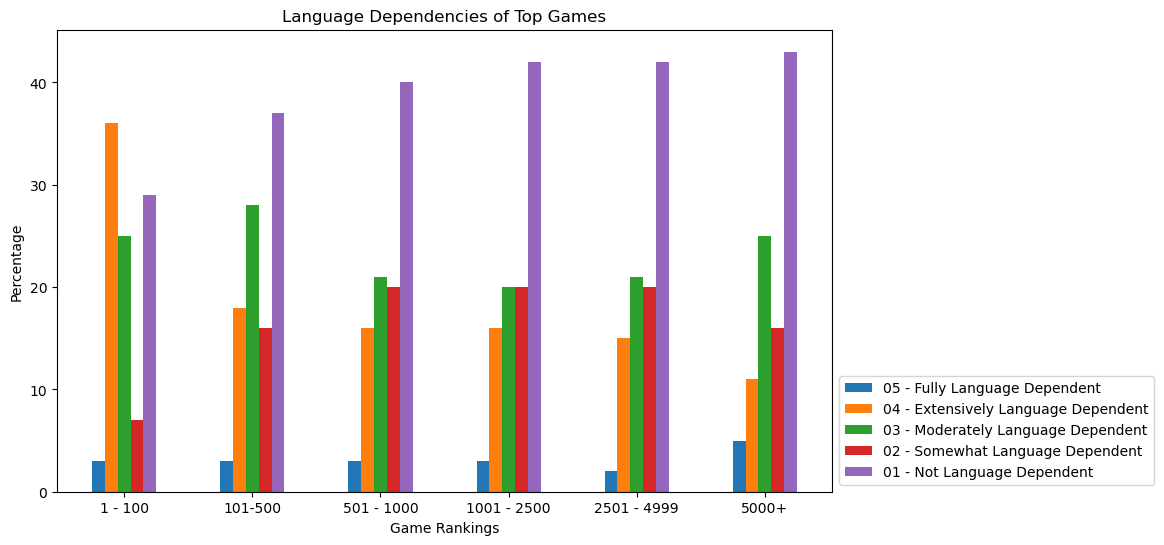

In [11]:
#setting up df info for plotting

# perc_fully = rankings_vs_lang_perc.iloc[1,:].tolist()
# perc_extensively = rankings_vs_lang_perc.iloc[0,:].tolist()
# perc_moderately = rankings_vs_lang_perc.iloc[2,:].tolist()
# perc_somewhat = rankings_vs_lang_perc.iloc[4,:].tolist()
# perc_not_dependent = rankings_vs_lang_perc.iloc[3,:].tolist()


l_rankings_vs_lang_perc = rankings_vs_lang_perc.applymap(lambda x: x * 100)

perc_fully = l_rankings_vs_lang_perc.loc["Fully",:].tolist()
perc_extensively = l_rankings_vs_lang_perc.loc["Extensively",:].tolist()
perc_moderately = l_rankings_vs_lang_perc.loc["Moderately",:].tolist()
perc_somewhat = l_rankings_vs_lang_perc.loc["Somewhat",:].tolist()
perc_not_dependent = l_rankings_vs_lang_perc.loc["Not Dependent",:].tolist()

bar_width = 0.1

# note chatgpt assisted code for ticks and bar positioning.
x_positions = [i for i in range(len(grouped_rankings))]

# plotting the bars graph
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar([pos - 2*bar_width for pos in x_positions], perc_fully, bar_width, label="05 - Fully Language Dependent")
ax.bar([pos - bar_width for pos in x_positions], perc_extensively, bar_width, label='04 - Extensively Language Dependent')
ax.bar(x_positions, perc_moderately, bar_width, label='03 - Moderately Language Dependent')
ax.bar([pos + bar_width for pos in x_positions], perc_somewhat, bar_width, label='02 - Somewhat Language Dependent')
ax.bar([pos + 2*bar_width for pos in x_positions], perc_not_dependent, bar_width, label='01 - Not Language Dependent')


# adding the labels and title
ax.set_xlabel('Game Rankings')
ax.set_ylabel('Percentage')
ax.set_title("Language Dependencies of Top Games")
ax.legend(loc="lower left", bbox_to_anchor=(1, 0))

plt.xticks(x_positions, grouped_rankings)

# display(rankings_vs_lang_perc)
# Show the plot
plt.show()

In [12]:
display(rankings_vs_lang)

ranked_above_100 = rankings_vs_lang[["101-500","501 - 1000", "1001 - 2500", "2501 - 4999", "5000+"]].sum(axis=1)
ranked_above_100

rankings_vs_lang_condensed = rankings_vs_lang.copy()
rankings_vs_lang_condensed["101+"] = ranked_above_100


rankings_vs_lang_condensed.drop(columns = ["101-500","501 - 1000", "1001 - 2500", "2501 - 4999", "5000+"], inplace = True)
display(rankings_vs_lang_condensed)
rankings_vs_lang_condensed_perc = rankings_vs_lang_condensed.apply(convert_to_percent).round(2) 

rankings_vs_lang_condensed_perc

,1 - 100,101-500,501 - 1000,1001 - 2500,2501 - 4999,5000+
lang,,,,,,
Not Dependent,29,147,199,625,1009,6018
Somewhat,7,62,100,302,474,2216
Moderately,25,110,107,297,506,3530
Extensively,36,70,80,233,350,1602
Fully,3,11,14,39,54,656


,1 - 100,101+
lang,,
Not Dependent,29,7998
Somewhat,7,3154
Moderately,25,4550
Extensively,36,2335
Fully,3,774


,1 - 100,101+
lang,,
Not Dependent,0.29,0.43
Somewhat,0.07,0.17
Moderately,0.25,0.24
Extensively,0.36,0.12
Fully,0.03,0.04


Analyses: 
    Language trends for the top 100 games are different

### 3. Plot to see the language dependencies for games per decades.

In [13]:
#plot lang and decades
lang_decades = games_rankings[["lang", "decade"]].copy()
lang_options = lang_decades["lang"].unique()

lang_vs_dec = pd.pivot_table(lang_decades, 
                                index = 'lang', 
                                columns = "decade",
                                aggfunc='size')

lang_vs_dec_perc = lang_vs_dec.apply(convert_to_percent).round(2)

reorder_lang_dec= ["Not Dependent", "Somewhat", "Moderately", "Extensively", "Fully"]

lang_vs_dec_perc = lang_vs_dec_perc.loc[reorder_lang_dec]

display(lang_vs_dec)
display(lang_vs_dec_perc)

lang_vs_dec.sum().sum()

decade,1960s,1970s,1980s,1990s,2000s,2010s,2020s
lang,,,,,,,
Extensively,8,30,84,175,453,1142,465
Fully,5,12,51,77,190,278,147
Moderately,33,340,449,471,746,1845,662
Not Dependent,75,181,301,632,1809,3645,1110
Somewhat,27,96,145,204,616,1609,429


decade,1960s,1970s,1980s,1990s,2000s,2010s,2020s
lang,,,,,,,
Not Dependent,0.51,0.27,0.29,0.41,0.47,0.43,0.39
Somewhat,0.18,0.15,0.14,0.13,0.16,0.19,0.15
Moderately,0.22,0.52,0.44,0.30,0.20,0.22,0.24
Extensively,0.05,0.05,0.08,0.11,0.12,0.13,0.17
Fully,0.03,0.02,0.05,0.05,0.05,0.03,0.05


18542

decade,1960s,1970s,1980s,1990s,2000s,2010s,2020s
lang,,,,,,,
Not Dependent,0.51,0.27,0.29,0.41,0.47,0.43,0.39
Somewhat,0.18,0.15,0.14,0.13,0.16,0.19,0.15
Moderately,0.22,0.52,0.44,0.30,0.20,0.22,0.24
Extensively,0.05,0.05,0.08,0.11,0.12,0.13,0.17
Fully,0.03,0.02,0.05,0.05,0.05,0.03,0.05


decade,1960s,1970s,1980s,1990s,2000s,2010s,2020s
lang,,,,,,,
Not Dependent,51.0,27.0,29.0,41.0,47.0,43.0,39.0
Somewhat,18.0,15.0,14.0,13.0,16.0,19.0,15.0
Moderately,22.0,52.0,44.0,30.0,20.0,22.0,24.0
Extensively,5.0,5.0,8.0,11.0,12.0,13.0,17.0
Fully,3.0,2.0,5.0,5.0,5.0,3.0,5.0


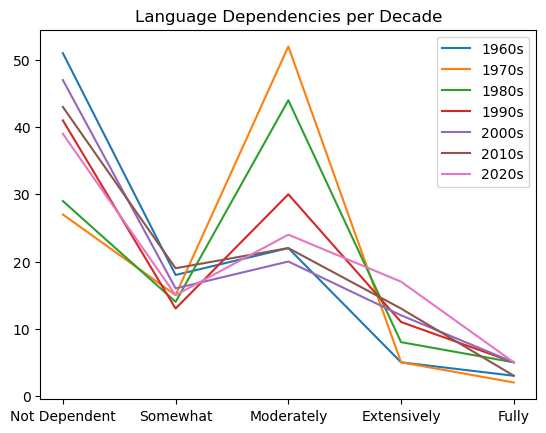

In [14]:
display(lang_vs_dec_perc)

l_lang_vs_dec_perc = lang_vs_dec_perc.applymap(lambda x: x * 100)
display(l_lang_vs_dec_perc)

decade_1960, = plt.plot(l_lang_vs_dec_perc.index, l_lang_vs_dec_perc["1960s"], label = "1960s")
decade_1970, = plt.plot(l_lang_vs_dec_perc.index, l_lang_vs_dec_perc["1970s"], label = "1970s")
decade_1980, = plt.plot(l_lang_vs_dec_perc.index, l_lang_vs_dec_perc["1980s"], label = "1980s")
decade_1990, = plt.plot(l_lang_vs_dec_perc.index, l_lang_vs_dec_perc["1990s"], label = "1990s")
decade_2000, = plt.plot(l_lang_vs_dec_perc.index, l_lang_vs_dec_perc["2000s"], label = "2000s")
decade_2010, = plt.plot(l_lang_vs_dec_perc.index, l_lang_vs_dec_perc["2010s"], label = "2010s")
decade_2020, = plt.plot(l_lang_vs_dec_perc.index, l_lang_vs_dec_perc["2020s"], label = "2020s")

plt.legend(handles=[decade_1960,decade_1970, decade_1980,decade_1990, decade_2000,decade_2010, decade_2020], loc = "best")
plt.title("Language Dependencies per Decade")
plt.show()

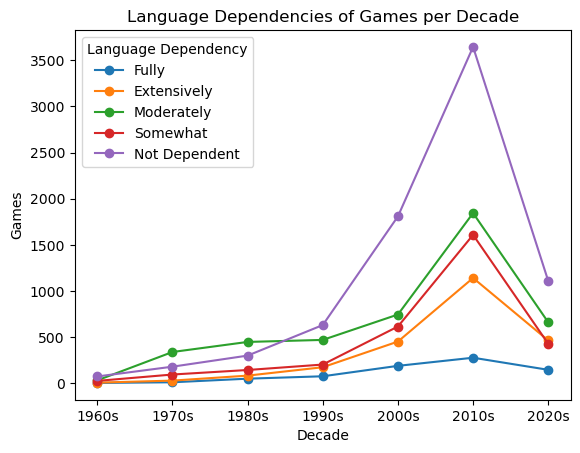

In [65]:
# Used some assistance from AI to understand to use a dictionary
df_dic = {"decade":list(lang_vs_dec.columns), 
         'Fully':list(lang_vs_dec.loc["Fully",:]),
         'Extensively':list(lang_vs_dec.loc["Extensively",:]),
         'Moderately':list(lang_vs_dec.loc["Moderately",:]),
         'Somewhat':list(lang_vs_dec.loc["Somewhat",:]),
         'Not Dependent':list(lang_vs_dec.loc["Not Dependent",:])}

df_dic
lang_vs_dec_plot = pd.DataFrame(df_dic)
lang_vs_dec_plot.set_index('decade', inplace=True)

# Plotting
fig, ax = plt.subplots()
lang_vs_dec_plot.plot(kind='line', marker='o', ax=ax)

ax.set_xlabel("Decade")
ax.set_ylabel("Games")
ax.legend(title='Language Dependency', loc='upper left')
ax.set_title("Language Dependencies of Games per Decade")
plt.show()


#### Other: Charted game mechanics and types of games against languages. It would be interesting in a future analyses to review if any correlations and trends could be ascertained.

In [ ]:
cat_merge_df = pd.merge(games_rankings[["@id", "name" , "year", "lang"]], df[["@id","categories", "mechanics"]], on = "@id", how = "inner")

In [ ]:
def metric_by_year(data, metric):
    new_df = data[['lang', metric]].copy()
    new_df = new_df.explode(metric).reset_index(drop=True)
    return new_df
    
lang_cats = metric_by_year(cat_merge_df, 'categories')
lang_mechs = metric_by_year(cat_merge_df, 'mechanics')
display(lang_cats.head())
lang_mechs.head()


In [ ]:
lang_vscats = pd.pivot_table(lang_cats, 
                              index = "categories",
                                columns = 'lang', 
                                aggfunc='size')

display(lang_vscats)
lang_vscats_perc = lang_vscats.apply(convert_to_percent).round(2)
lang_vscats_perc

In [ ]:
lang_vsmech = pd.pivot_table(lang_mechs, 
                              index = "mechanics",
                                columns = 'lang', 
                                aggfunc='size')

display(lang_vsmech)
lang_vsmech_perc = lang_vsmech.apply(convert_to_percent).round(2)
lang_vsmech_perc